In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
## Element stiffness matrices for a truss element
class GreenTrussElement:
    def __init__(self,GlobalInitPosition,GlobalDisplacement,E,A0):
        #GlobalInitPosition # X1 Y1 X2 Y2 global coordinates of the nodes
        #GlobalDisplacement # u1 v1 u2 v2 global displacement vector
        self.GlobalInitPosition=GlobalInitPosition
        self.GlobalDisplacement=GlobalDisplacement
        self.E=E
        self.A0=A0
        self.l0=np.sqrt((GlobalInitPosition[2]-GlobalInitPosition[0])**2+(GlobalInitPosition[3]-GlobalInitPosition[1])**2)
        
    def ElementChar(self):


        self.x21=self.GlobalInitPosition[2]-self.GlobalInitPosition[0]
        self.y21=self.GlobalInitPosition[3]-self.GlobalInitPosition[1]
        self.u21=self.GlobalDisplacement[2]-self.GlobalDisplacement[0]
        self.v21=self.GlobalDisplacement[3]-self.GlobalDisplacement[1]
        
        self.b=(np.transpose(np.array([-(self.x21+self.u21), -(self.y21+self.v21), (self.x21+self.u21), (self.y21+self.v21)])))/(self.l0**2)
        self.epsilon=(2*self.x21*self.u21 + 2*self.y21*self.v21 +self.u21**2 +self.v21**2)/(2*self.l0*2)
        self.sigma=self.E*self.epsilon
        K_a=np.array([[1,0,-1,0],[0,1,0,-1],[-1,0,1,0],[0 ,-1, 0 ,1]])/(self.l0**2)
        self.q=self.A0*self.l0*self.sigma*np.transpose(self.b)
        #K= A0L0(b'EB+sigma+K_a)
        self.K= self.A0*self.l0*(self.E*(np.transpose(self.b)).dot(self.b)+ self.sigma*K_a)
        
    
    

In [3]:
## Global Stiffness Matrix and Force Matrices
def Assemble(K_elements):
    NumOfElements=K_elements.shape[0]
    # K_elements is the tensor of (NumOfElements)*4*4
    K=np.zeros(((NumOfElements+1)*2,(NumOfElements+1)*2))
    for i in range(NumOfElements):
        K_temp=np.zeros(((NumOfElements+1)*2,(NumOfElements+1)*2))
        K_temp=K_elements[i,:,:]
        K[(i)*2:(i)*2+4,(i)*2:(i)*2+4] +=K_temp
    return K


In [4]:
## Global Force vector
F=(np.array([[0, 0, 0, -1, 0, 0]])).T

In [5]:
## Force Control
tol=0.001
A0=.01
E=2*100000
NumberOfPoints=10
element1=GreenTrussElement([0,0,1,.1],np.zeros((4,1)),E,A0)
element1.ElementChar()
element2=GreenTrussElement([1,.1,1.5,0],np.zeros((4,1)),E,A0)
element2.ElementChar()
K_elements=np.zeros((2,4,4))
q=np.zeros((6,1))
d=np.zeros((6,1))
g=np.zeros((6,1))
F_plot=np.zeros((NumberOfPoints,1))
d_plot=np.zeros((NumberOfPoints,6))
for i in range(1,NumberOfPoints*2,2):
     
     landa=i*0.1
     g=q-landa*F
     F_plot[int((i-1)/2)]=landa*1
     r=abs(g[3])
     d_plot[int((i-1)/2),:]=d[:,0]
     while r>tol:
        
        element1.GlobalDisplacement=d[0:4]
        element2.GlobalDisplacement=d[2:6]
        element1.ElementChar()
        element2.ElementChar()
        
        K1=element1.K
        K2=element2.K
        K_elements[0,:,:]=K1
        K_elements[1,:,:]=K2
        
        K=Assemble(K_elements)
        for counter in [0,1,4,5]:
                K[counter,:]=np.zeros((1,6))
                K[:,counter]=np.zeros((1,6))
        for i in [0,1,4,5]:
                K[i,i]=1
                
        delta_d=-np.matmul(np.linalg.inv(K),(g))
        
        d=d+delta_d
        
        element1.GlobalDisplacement=d[0:4]
        element2.GlobalDisplacement=d[2:6]
        element1.ElementChar()
        element2.ElementChar()        
        
        q1=element1.q
        q2=element2.q
        
        q=np.array([[0,0,q1[2]+q2[0],q1[3]+q2[1],0,0]]).T
        g=q-landa*F

        r=abs(g[3])        

    
        



Text(0, 0.5, '-F')

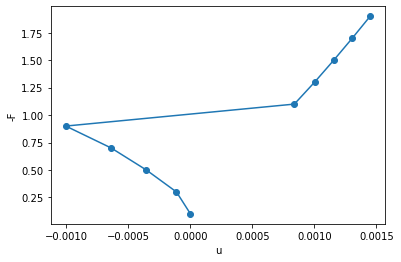

In [6]:
## Plotting
plt.plot(d_plot[:,2] ,F_plot,'o-')
plt.xlabel('u')
plt.ylabel('-F')


Text(0, 0.5, '-F')

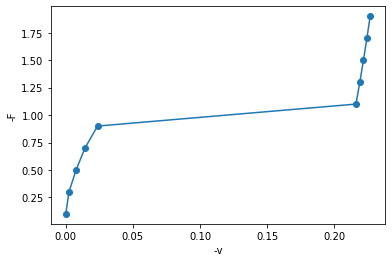

In [7]:
plt.plot(-d_plot[:,3] ,F_plot,'o-')
plt.xlabel('-v')
plt.ylabel('-F')

In [8]:
## Displacement Control
tol=0.003
A0=.01
E=2*100000
NumberOfPoints=20

element1=GreenTrussElement([0,0,1,.1],np.zeros((4,1)),E,A0)
element1.ElementChar()

element2=GreenTrussElement([1,.1,1.5,0],np.zeros((4,1)),E,A0)
element2.ElementChar()

K_elements=np.zeros((2,4,4))

q=np.zeros((6,1))

g=np.zeros((6,1))
#F=np.zeros((6,1))
K_a=np.zeros((7,7))
K_a[6,3]=1
K_a[0:6,6]=[0, 0, 0, +1, 0, 0]

F_plot=np.zeros((NumberOfPoints,1))
d_plot=np.zeros((NumberOfPoints,7))
g_temp=np.array([0])

landa=0

for i in range(0,NumberOfPoints,1):
    
     # Initial guess for solving 7 equations
     d=np.zeros((7,1))
     d[3]=-.01*i
     F_plot[(i-1)]=landa*1
     #d_plot[(i-1),:]=d[:,0] 
     r=1
     counter2=1
     while r>tol or counter2<10:

        counter2+=1
        # finding K to Construct K_a
        element1.GlobalDisplacement=d[0:4]
        element2.GlobalDisplacement=d[2:6]
        element1.ElementChar()
        element2.ElementChar()        
        K1=element1.K
        K2=element2.K
        K_elements[0,:,:]=K1
        K_elements[1,:,:]=K2
        
        K=Assemble(K_elements)
        for counter in [0,1,4,5]:
                K[counter,:]=np.zeros((1,6))
                K[:,counter]=np.zeros((1,6))
        for j in [0,1,4,5]:
                K[j,j]=1
        
        K_a[0:6,0:6]=K
        
        g_temp=d[3]+.01*i
        
        G=np.vstack([g,g_temp])
        
        delta_d_landa=-np.matmul(np.linalg.inv(K_a),(G))
        
        d=d+delta_d_landa

        landa=d[6]

        element1.GlobalDisplacement=d[0:4]
        element2.GlobalDisplacement=d[2:6]

        element1.ElementChar()
        element2.ElementChar()        
        
        q1=element1.q
        q2=element2.q
        
        q=np.array([[0,0,q1[2]+q2[0],q1[3]+q2[1],0,0]]).T
        g=q-landa*F
        r=abs(G[0])+abs(G[1])+abs(G[2])+abs(G[3])+abs(G[4])+abs(G[5])+abs(G[6])
        if r < tol and counter2>3:
            d_plot[i,:]=d[:,0]
        



Text(0, 0.5, '-F')

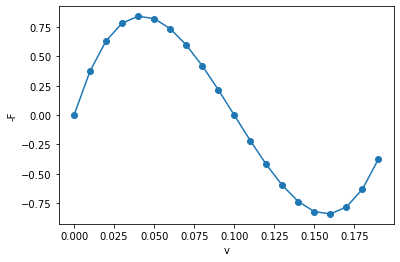

In [9]:
## Plotting

plt.plot(-d_plot[:,3] ,d_plot[:,-1],'o-')
plt.xlabel('v')
plt.ylabel('-F')


Text(0, 0.5, '-F')

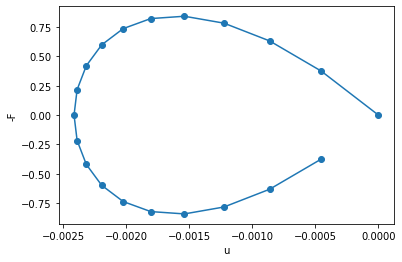

In [10]:
plt.plot(d_plot[:,2] ,d_plot[:,-1],'o-')
plt.xlabel('u')
plt.ylabel('-F')